In [41]:
import numpy as np
import matplotlib.pyplot as plt



# Parameters
a = 0.0  # Coefficient for x^3 term
b = 1.0  # Coefficient for x^4 term
beta = 1.0  # Inverse temperature

# Step 1: Load the data and process it as before
all_positions = []
current_block = []

with open('condizioni_iniziali.dat', 'r') as f:  # Replace 'your_file.txt' with your actual filename
    for line in f:
        line = line.strip()
        if line and '-' not in line:  # Ignore separator lines
            position = float(line.split()[0])  # Extract the position (first column)
            current_block.append(position)
        elif current_block:  # If we hit a separator, save the block
            all_positions.append(current_block)
            current_block = []

    if current_block:  # Save the last block if no separator at end
        all_positions.append(current_block)

# Step 2: Calculate differences within each block
position_diffs = []
for block in all_positions:
    if len(block) > 1:
        diffs = np.diff(block)
        position_diffs.extend(diffs)

# Step 3: Plot histogram of position differences
plt.hist(position_diffs, bins=40, density=True, alpha=0.6, edgecolor='black', label='Position Differences')

# Step 4: Define the energy function and density based on Boltzmann distribution
def energy(x, a, b):
    return (x-1)**2/2 + a * (x-1)**3/3 + b * (x-1)**4/4

def density(x, a, b, beta):
    return np.exp(-beta * energy(x, a, b))

# Generate x values for plotting the density
x_vals = np.linspace(min(position_diffs), max(position_diffs), 500)
density_vals = density(x_vals, a, b, beta)
density_vals /= np.trapz(density_vals, x_vals)  # Normalize the density

# Step 5: Plot the density function
plt.plot(x_vals, density_vals, color='red', linewidth=2, label='Energy-based Density')

# Add labels and legend
plt.xlabel('Difference between consecutive positions')
plt.ylabel('Probability Density')
plt.title('Histogram of Position Differences with Energy-based Density')
plt.legend()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'condizioni_iniziali.dat'

(5000, 64)


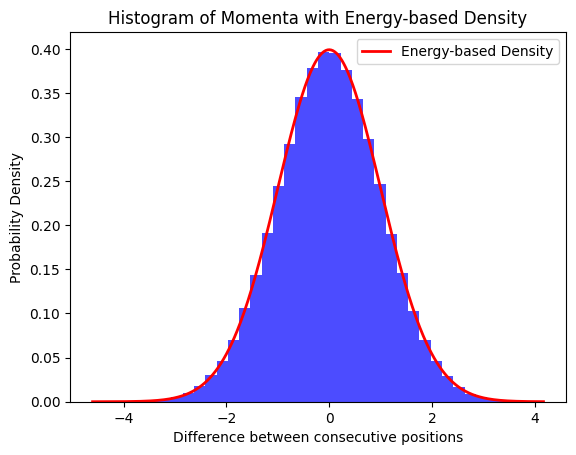

In [1]:
import numpy as np
import os
import random

def read_conditions(filename, num_condizioni, neq):
    # Verifica se il file esiste
    if not os.path.exists(filename):
        print("Errore nell'apertura del file per lettura!")
        return None
    
    # Dimensione di una condizione in byte
    dimensione_condizione = neq * np.dtype('float64').itemsize
    
    # Ottieni la dimensione totale del file
    file_size = os.path.getsize(filename)
    
    # Calcola il numero di condizioni nel file
    numero_condizioni_tot = file_size // dimensione_condizione
    
    if num_condizioni > numero_condizioni_tot:
        print("Errore: il numero di condizioni richiesto eccede il numero di condizioni nel file.")
        return None

    # Inizializza il vettore per le condizioni
    condizioni = np.empty(num_condizioni * neq, dtype='float64')

    # Apri il file in modalità binaria
    with open(filename, 'rb') as inFile:
        for i in range(num_condizioni):
            # Seleziona un indice casuale
            indice_casuale = random.randint(0, numero_condizioni_tot - 1)
            
            # Calcola l'offset dell'indice
            offset = indice_casuale * dimensione_condizione
            
            # Posizionarsi nel file all'offset desiderato
            inFile.seek(offset)
            
            # Leggi la condizione e mettila nel vettore
            condition_data = np.fromfile(inFile, dtype='float64', count=neq)
            if condition_data.size != neq:
                print("Errore durante la lettura del file!")
                return None
            
            condizioni[i * neq : (i + 1) * neq] = condition_data

    return condizioni


filename = "condizioni.bin"
num_condizioni = 5000  # Numero di condizioni da leggere
N=30
dim=1
neq= (N+2)*2*dim + 2

condizioni = read_conditions(filename, num_condizioni, neq)
if condizioni is not None:
    cond_t=condizioni.reshape(num_condizioni,neq)[:,:neq-2]
print(cond_t.shape)


import numpy as np
import matplotlib.pyplot as plt

# Supponendo che `cond_t` sia già definito
# Estrai solo le colonne di `x` per ciascuna catena
x_values = cond_t[:, ::2]  # Prende solo le colonne alternate, che sono i valori `x`
p_values=np.concatenate(cond_t[:, 3:-2:2])
# Calcola le differenze tra valori successivi di `x` per ciascuna catena (prima dimensione)
diff_x_all = [np.diff(x_chain) for x_chain in x_values]

# Unisci tutte le differenze in un singolo array per l'istogramma
diff_x_all = np.concatenate(diff_x_all)

# Crea l'istogramma delle differenze
plt.hist(p_values, bins=40, density=True, alpha=0.7, color='blue')

def energy(x, a, b):
    return x**2/2#(x-1)**2/2 + a * (x-1)**3/3 + b * (x-1)**4/4

def density(x, a, b, beta):
    return np.exp(-beta * energy(x, a, b))

# Generate x values for plotting the density
x_vals = np.linspace(min(p_values), max(p_values), 500)
density_vals = density(x_vals, 0, 1, 1)
density_vals /= np.trapz(density_vals, x_vals)  # Normalize the density

# Step 5: Plot the density function
plt.plot(x_vals, density_vals, color='red', linewidth=2, label='Energy-based Density')

# Add labels and legend
plt.xlabel('Difference between consecutive positions')
plt.ylabel('Probability Density')
plt.title('Histogram of Momenta with Energy-based Density')
plt.legend()
plt.show()

[0.00000000e+00 1.00009268e-04 2.00018536e-04 ... 1.07889998e+00
 1.07899999e+00 1.07910000e+00]
[-2.4287 -2.4287 -2.4287 ... -2.7313 -2.7316 -2.7318]
[-2.4287e-04 -4.8573e-04 -7.2860e-04 ... -2.4300e+00 -2.4303e+00
 -2.4305e+00]


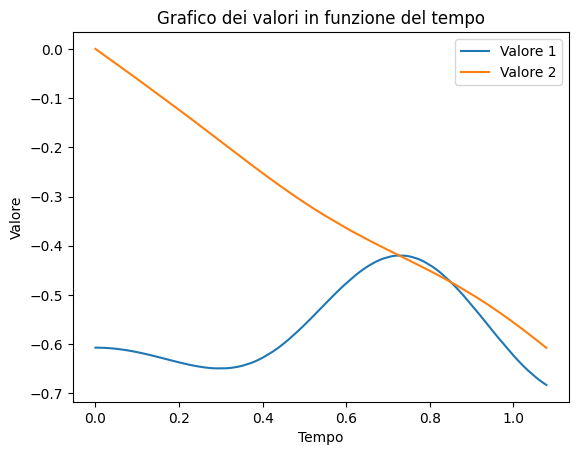

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid
# Carica i dati dal file
data = np.loadtxt('ttcf.dat')


# Assegna ogni colonna a una variabile
def moving_average(arr, window_size):
    return np.convolve(arr, np.ones(window_size) / window_size, mode='valid')



tempo = np.linspace(0,len(data[:, 1])*10**(-4),len(data[:, 1]))

valore1 = data[:, 0]
valore2 = data[:, 1]#moving_average( cumulative_trapezoid(smoothed_series, time[:len(smoothed_series)],initial=0), window_size=1000)#data[0::1, 2]#cumulative_trapezoid(smoothed_series, time[:len(smoothed_series)],initial=0)
#valore3 = data[0::1, 3]
print(tempo)
print(valore1)
print(valore2)
# Crea il grafico
plt.figure()
plt.plot(tempo,valore1/4, label='Valore 1')
plt.plot(tempo, valore2/4, label='Valore 2')
#plt.plot(tempo, valore3, label='Valore 3')
 

# Etichetta gli assi
plt.xlabel('Tempo')
plt.ylabel('Valore')
plt.title('Grafico dei valori in funzione del tempo')
plt.legend()

# Mostra il grafico
plt.show()

In [7]:
print(tempo[-2])

36.515
